In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install folium==0.2.1
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 7.9 MB/s 
  Created wheel for folium: filename=folium-0.2.1-py3-none-any.whl size=79808 sha256=e7d19f43e0459ee8c42c9b9541eec04e394ca1d05a2cd8832b8b6f8a558240b5
  Stored in directory: /root/.cache/pip/wheels/9a/f0/3a/3f79a6914ff5affaf50cabad60c9f4d565283283c97f0bdccf
Successfully built folium
  Attempting uninstall: folium
    Found existing installation: folium 0.8.3
    Uninstalling folium-0.8.3:
      Successfully uninstalled folium-0.8.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 27.9 MB/s 


In [3]:
!pip install -q transformers
!pip install -q datasets

     |████████████████████████████████| 4.4 MB 18.3 MB/s 
     |████████████████████████████████| 6.6 MB 47.9 MB/s 
     |████████████████████████████████| 596 kB 43.8 MB/s 
     |████████████████████████████████| 101 kB 11.7 MB/s 
     |████████████████████████████████| 362 kB 10.7 MB/s 
     |████████████████████████████████| 212 kB 57.4 MB/s 
     |████████████████████████████████| 140 kB 65.3 MB/s 
     |████████████████████████████████| 1.1 MB 66.1 MB/s 
     |████████████████████████████████| 127 kB 75.4 MB/s 
     |████████████████████████████████| 94 kB 4.5 MB/s 
     |████████████████████████████████| 271 kB 72.6 MB/s 
     |████████████████████████████████| 144 kB 75.8 MB/s 


In [4]:
import torch
from datasets import load_dataset
import pandas as pd
import collections
from datasets import load_dataset , load_metric
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
from transformers import TrainingArguments, Trainer
from transformers import default_data_collator

In [5]:
dataset = load_dataset("Shayanvsf/ParSQuAD") # two available modes
dataset_eval = load_dataset("Shayanvsf/pquad_public")


Please Enter your desire mode(manual / automatic) :manual


Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

/root/.cache/huggingface/datasets/downloads/97ed8736ab42b51abce02f9a5dcbb958a09b958ed194531ae7f9bb0ff935208b


Generating validation split: 0 examples [00:00, ? examples/s]

/root/.cache/huggingface/datasets/downloads/13c29e41def66551bca1fcaed06c03c0939876d6641627d49910939b20e6ab49
Dataset par_s_qu_ad downloaded and prepared to /root/.cache/huggingface/datasets/Shayanvsf___par_s_qu_ad/ParSQuAD/1.0.0/124ac9a0ce7760ed368457a321c510f7c5592f9fa8026e6643cfe3d551b5d0d3. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

/root/.cache/huggingface/datasets/downloads/c398ba29001242851de4d8dc468625e7eeccc2041e8168871e972293b3745bde


Generating validation split: 0 examples [00:00, ? examples/s]

/root/.cache/huggingface/datasets/downloads/d87772b342fcc0d549d5a7a63e6b8873e2ae95e5c07919932e587397f545910d


Generating test split: 0 examples [00:00, ? examples/s]

/root/.cache/huggingface/datasets/downloads/e6f3da0212a37e85850d4f58a11a3e7bff446fcd83b57e8aeb54bbafa8ed95c8
Dataset pquad_public downloaded and prepared to /root/.cache/huggingface/datasets/Shayanvsf___pquad_public/pquad_public/1.0.0/20f4f02802eb56c6b1f41e0fd9e4b3452884817ce8592df8fe863576c1569264. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 18906
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 5711
    })
})

In [7]:
dataset['train'] = dataset['train'].remove_columns("id")
dataset['validation'] = dataset['validation'].remove_columns("id")

In [8]:
new_column_train = range(0,len(dataset['train']))
dataset['train'] = dataset['train'].add_column('id',new_column_train)
new_column_validation = range(0,len(dataset['validation']))
dataset['validation'] = dataset['validation'].add_column('id',new_column_validation)

#Loading datasets

In [9]:
dataset

DatasetDict({
    train: Dataset({
        features: ['title', 'context', 'question', 'answers', 'id'],
        num_rows: 18906
    })
    validation: Dataset({
        features: ['title', 'context', 'question', 'answers', 'id'],
        num_rows: 5711
    })
})

In [10]:
dataset_eval

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 7878
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 1157
    })
    test: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 964
    })
})

## Train Data

In [11]:
pd.DataFrame(data = dataset['train']).head()

,title,context,question,answers,id
0,بیانسه,بیانسه جیزل نوولز-کارتر (/ biːˈjɒnseɪ / bee-YO...,از چه زمانی بیانسه شروع به محبوبیت کرد؟,"{'text': ['در اواخر دهه 1990'], 'answer_start'...",0
1,بیانسه,بیانسه جیزل نوولز-کارتر (/ biːˈjɒnseɪ / bee-YO...,چه موقع بیانسه Destiny's Child را ترک کرد و یک...,"{'text': ['2003'], 'answer_start': [476]}",1
2,بیانسه,بیانسه جیزل نوولز-کارتر (/ biːˈjɒnseɪ / bee-YO...,در چه دهه ای بیانسه مشهور شد؟,"{'text': ['اواخر دهه 1990'], 'answer_start': [...",2
3,بیانسه,بیانسه جیزل نوولز-کارتر (/ biːˈjɒnseɪ / bee-YO...,چه کسی گروه Destiny's Child را مدیریت می کرد؟,"{'text': ['ماتیو نولز'], 'answer_start': [323]}",3
4,بیانسه,بیانسه جیزل نوولز-کارتر (/ biːˈjɒnseɪ / bee-YO...,چه موقع بیانسه به شهرت رسید؟,"{'text': ['اواخر دهه 1990'], 'answer_start': [...",4


## Validation Data

In [12]:
pd.DataFrame(data = dataset['validation']).head()

,title,context,question,answers,id
0,نورمن ها,نورمن ها (نورمن: Nourmands ؛ فرانسوی: Normands...,نرماندی در کدام کشور واقع شده است؟,"{'text': ['فرانسه', 'فرانسه', 'فرانسه', 'فرانس...",0
1,نورمن ها,نورمن ها (نورمن: Nourmands ؛ فرانسوی: Normands...,نورمن ها چه زمانی در نرماندی بودند؟,"{'text': ['قرون 10 و 11', 'در قرون 10 و 11', '...",1
2,نورمن ها,نورمن ها (نورمن: Nourmands ؛ فرانسوی: Normands...,نژاد نورس از کدام کشورها است؟,"{'text': ['دانمارک ، ایسلند و نروژ', 'دانمارک ...",2
3,نورمن ها,نورمن ها (نورمن: Nourmands ؛ فرانسوی: Normands...,چه کسی نام خود را در 1000 و 1100 به نرماندی دا...,"{'text': [], 'answer_start': []}",3
4,نورمن ها,نورمن ها (نورمن: Nourmands ؛ فرانسوی: Normands...,فرانسه چه منطقه ای است؟,"{'text': [], 'answer_start': []}",4


## Model Init

In [13]:
model_checkpoint = "m3hrdadfi/albert-fa-base-v2"
max_length = 256 #512 # The maximum length of a feature (question and context)
doc_stride = 128 # 256 # The authorized overlap between two part of the context when splitting it is needed.
batch_size = 8
lr = 3e-5
epoch = 3

In [14]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/684 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

In [15]:
tokenizer(".اسمتون چی بود ؟", "اسم من شایان است")

{'input_ids': [2, 11, 7, 36254, 4781, 4322, 46, 2125, 3, 2415, 111, 3800, 20, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

## Create several input features from long contex

In [16]:
for i, example in enumerate(dataset["train"]):
    if len(tokenizer(example["question"], example["context"])["input_ids"]) > max_length:
        print('Find one')
        break
        
example = dataset["train"][i]

Find one


In [17]:
example

{'answers': {'answer_start': [297], 'text': ['بازیگری']},
 'context': 'پس از انحلال Destiny\'s Child در ژوئن 2005 ، او دومین آلبوم انفرادی خود را با نام B\'Day. (2006) منتشر کرد که حاوی آهنگ های "دژاوو" ، "بی بدیل" و "دروغگو زیبا" بود. بیانسه همچنین با بازی در دختران خواب (2006) نامزد دریافت گلدن گلوب و بازی در نقش های مختلف در فیلم پلنگ صورتی (2006) و وسواس (2009) به بازیگری روی آورد. ازدواج او با رپ جی Z و به تصویر کشیدن اتا جیمز در کادیلاک رکوردز (2008) بر روی سومین آلبوم او تحت عنوان I Am ... Sasha Fierce (2008) تأثیر گذاشت ، که تولد متخاصم او ساشا Fierce بود و یک رکورد ثبت شد شش جایزه گرمی در سال 2010 ، از جمله آهنگ سال برای "مجردها (روی آن انگشتر بگذارید)". بیانسه در سال 2010 از موسیقی وقفه گرفت و مدیریت حرفه خود را به عهده گرفت. چهارمین آلبوم او 4 (2011) متعاقبا از نظر لحن متنوع تر بود و با کاوش در فانک های دهه 1970 ، پاپ دهه 1980 و روح 1990s. پنجمین آلبوم استودیویی مورد تحسین منتقدان ، بیانسه (2013) ، با تولید آزمایشی و بررسی مضامین تیره تر از نسخه های قبلی متمایز شد.',
 'id': 

In [18]:
len(tokenizer(example["question"], example["context"])["input_ids"])

283

In [19]:
len(tokenizer(example["question"], example["context"], max_length = max_length, truncation="only_second")["input_ids"])

256

## return_overflowing_tokens

In [20]:
tokenized_example = tokenizer(
    example["question"],
    example["context"],
    max_length = max_length,
    truncation="only_second",
    return_overflowing_tokens=True,
    stride=doc_stride
)

In [21]:
[len(x) for x in tokenized_example["input_ids"]] 

[256, 173]

In [22]:
len(tokenized_example["input_ids"])

2

In [23]:
for x in tokenized_example["input_ids"][:2]:
    print(tokenizer.decode(x))

[CLS] بعد از دومین البوم انفرادی ، بیانسه چه سرگرمی دیگری را جستجو کرد؟[SEP] پس از انحلال destiny's child در ژو<unk>ن <unk> ، او دومین البوم انفرادی خود را با نام b'day. (<unk>) منتشر کرد که حاوی اهنگ های "دژاوو" ، "بی بدیل" و "دروغگو زیبا" بود. بیانسه همچنین با بازی در دختران خواب (<unk>) نامزد دریافت گلدن گلوب و بازی در نقش های مختلف در فیلم پلنگ صورتی (<unk>) و وسواس (<unk>) به بازیگری روی اورد. ازدواج او با رپ جی z و به تصویر کشیدن اتا جیمز در کادیلاک رکوردز (<unk>) بر روی سومین البوم او تحت عنوان i am... sasha fierce (<unk>) تاثیر گذاشت ، که تولد متخاصم او ساشا fierce بود و یک رکورد ثبت شد شش جایزه گرمی در سال <unk> ، از جمله اهنگ سال برای "مجردها (روی ان انگشتر بگذارید)". بیانسه در سال <unk> از موسیقی وقفه گرفت و مدیریت حرفه خود را به عهده گرفت. چهارمین البوم او <unk> (<unk>) متعاقبا از نظر لحن متنوع تر بود و با کاوش در فانک های دهه <unk> ، پاپ دهه <unk> و روح <unk>s. پنجمین البوم استودیوی[SEP]
[CLS] بعد از دومین البوم انفرادی ، بیانسه چه سرگرمی دیگری را جستجو کرد؟[SEP] رکوردز (<

## offset_mapping

In [24]:
tokenized_example = tokenizer(
    example["question"],
    example["context"],
    max_length=max_length,
    truncation="only_second",
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
    stride=doc_stride
)
print(tokenized_example["offset_mapping"][0][:100])

[(0, 0), (0, 3), (3, 6), (6, 12), (12, 18), (18, 26), (26, 28), (28, 33), (33, 35), (35, 38), (38, 45), (45, 51), (51, 54), (54, 60), (60, 64), (64, 65), (0, 0), (0, 2), (2, 5), (5, 12), (12, 19), (19, 20), (20, 21), (21, 22), (22, 23), (23, 28), (28, 31), (31, 34), (34, 35), (35, 36), (36, 37), (37, 41), (41, 43), (43, 46), (46, 52), (52, 58), (58, 66), (66, 70), (70, 73), (73, 76), (76, 80), (80, 82), (82, 83), (83, 86), (86, 87), (87, 89), (89, 93), (93, 94), (94, 100), (100, 104), (104, 107), (107, 108), (108, 112), (112, 113), (113, 117), (117, 121), (121, 123), (123, 125), (125, 128), (128, 129), (129, 131), (131, 133), (133, 135), (135, 140), (140, 141), (141, 143), (143, 145), (145, 146), (146, 149), (149, 151), (151, 156), (156, 157), (157, 161), (161, 162), (162, 167), (167, 169), (169, 176), (176, 179), (179, 184), (184, 187), (187, 194), (194, 199), (199, 201), (201, 205), (205, 206), (206, 212), (212, 219), (219, 224), (224, 229), (229, 231), (231, 236), (236, 239), (239, 

In [25]:
len(tokenized_example["offset_mapping"])

2

In [26]:
first_token_id = tokenized_example["input_ids"][0][1]
offsets = tokenized_example["offset_mapping"][0][1]
print(tokenizer.convert_ids_to_tokens([first_token_id])[0], example["question"][offsets[0]:offsets[1]])

▁بعد بعد


## return 0 if a token is in the question, else return 1.

In [27]:
sequence_ids = tokenized_example.sequence_ids()
print(sequence_ids)

[None, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, None, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, None]


## Detecting start and end character of a anwser

In [28]:
answers = example["answers"]
start_char = answers["answer_start"][0]
end_char = start_char + len(answers["text"][0])

# Start token index of the current span in the text.
token_start_index = 0
while sequence_ids[token_start_index] != 1:
    token_start_index += 1

# End token index of the current span in the text.
token_end_index = len(tokenized_example["input_ids"][0]) - 1
while sequence_ids[token_end_index] != 1:
    token_end_index -= 1

# Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
offsets = tokenized_example["offset_mapping"][0]
if (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char): # searching in the context
    # Move the token_start_index and token_end_index to the two ends of the answer.
    # Note: we could go after the last offset if the answer is the last word (edge case).
    while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
        token_start_index += 1
    start_position = token_start_index - 1
    while offsets[token_end_index][1] >= end_char:
        token_end_index -= 1
    end_position = token_end_index + 1
    print(start_position, end_position)
else:
    print("The answer is not in this feature.")

108 108


In [29]:
print(tokenizer.decode(tokenized_example["input_ids"][0][start_position: end_position+1]))
print(answers["text"][0])

بازیگری
بازیگری


## Putting it all together

In [30]:
def prepare_train_features(examples):
    examples["question"] = [q.lstrip() for q in examples["question"]]
    #Assume padding on the right.
    tokenized_examples = tokenizer(
        examples["question"],
        examples["context"],
        truncation="only_second",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,)
    
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping") #extract overflow_to_sample_mapping
    offset_mapping = tokenized_examples.pop("offset_mapping") #extract offset_mapping
    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []
    for i, offsets in enumerate(offset_mapping):
        # We will label impossible answers with the index of the CLS token.
        input_ids = tokenized_examples["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)
        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)
        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        answers = examples["answers"][sample_index]
        # If no answers are given, set the cls_index as answer.
        if len(answers["answer_start"]) == 0:
            tokenized_examples["start_positions"].append(cls_index)
            tokenized_examples["end_positions"].append(cls_index)
        else:
            # Start/end character index of the answer in the text.
            start_char = answers["answer_start"][0]
            end_char = start_char + len(answers["text"][0])
            # Start token index of the current span in the text.
            token_start_index = 0
            while sequence_ids[token_start_index] != 1:
                token_start_index += 1
            # End token index of the current span in the text.
            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != 1:
                token_end_index -= 1
            # Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
            if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
                tokenized_examples["start_positions"].append(cls_index)
                tokenized_examples["end_positions"].append(cls_index)
            else:
                # Otherwise move the token_start_index and token_end_index to the two ends of the answer.
                # Note: we could go after the last offset if the answer is the last word (edge case).
                while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                    token_start_index += 1
                tokenized_examples["start_positions"].append(token_start_index - 1)
                while offsets[token_end_index][1] >= end_char:
                    token_end_index -= 1
                tokenized_examples["end_positions"].append(token_end_index + 1)

    return tokenized_examples

In [31]:
# the datasets library does cashing itself, batched is multitreading for fast-tokenizer
tokenized_ds = dataset.map(prepare_train_features, batched=True, remove_columns=dataset["train"].column_names)

Parameter 'function'=<function prepare_train_features at 0x7fee9c6504d0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/19 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

In [32]:
model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/69.7M [00:00<?, ?B/s]

Some weights of the model checkpoint at m3hrdadfi/albert-fa-base-v2 were not used when initializing AlbertForQuestionAnswering: ['predictions.LayerNorm.bias', 'predictions.dense.weight', 'sop_classifier.classifier.bias', 'predictions.decoder.bias', 'predictions.bias', 'predictions.dense.bias', 'predictions.LayerNorm.weight', 'sop_classifier.classifier.weight', 'predictions.decoder.weight']
- This IS expected if you are initializing AlbertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForQuestionAnswering were not initialized from the model checkpoint at m3hrdadfi/albert-fa-base-v2

In [43]:
model_name = model_checkpoint.split("/")[-1]
args = TrainingArguments(
    output_dir = f"/content/drive/MyDrive/CA6/checkpoints/{model_name}-finetuned-ParSQuAD",
    #overwrite_output_dir = True,
    #save_strategy = "steps",
    #save_steps = 8000,
    evaluation_strategy = "epoch",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epoch,
    weight_decay=0.0001)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [44]:
data_collator = default_data_collator
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_ds['train'],
    eval_dataset=tokenized_ds['validation'],
    tokenizer=tokenizer)

In [45]:
# start training
trainer.train()
#trainer.save_model(trainer.save_model("PersianQA(ParsBERT)-trained"))

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 21166
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 7938


Epoch,Training Loss,Validation Loss
1,1.434200,1.504050
2,0.752100,1.893190
3,0.332000,2.602487


Saving model checkpoint to /content/drive/MyDrive/CA6/checkpoints/albert-fa-base-v2-finetuned-ParSQuAD/checkpoint-500
Configuration saved in /content/drive/MyDrive/CA6/checkpoints/albert-fa-base-v2-finetuned-ParSQuAD/checkpoint-500/config.json
Model weights saved in /content/drive/MyDrive/CA6/checkpoints/albert-fa-base-v2-finetuned-ParSQuAD/checkpoint-500/pytorch_model.bin
tokenizer config file saved in /content/drive/MyDrive/CA6/checkpoints/albert-fa-base-v2-finetuned-ParSQuAD/checkpoint-500/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/CA6/checkpoints/albert-fa-base-v2-finetuned-ParSQuAD/checkpoint-500/special_tokens_map.json
Saving model checkpoint to /content/drive/MyDrive/CA6/checkpoints/albert-fa-base-v2-finetuned-ParSQuAD/checkpoint-1000
Configuration saved in /content/drive/MyDrive/CA6/checkpoints/albert-fa-base-v2-finetuned-ParSQuAD/checkpoint-1000/config.json
Model weights saved in /content/drive/MyDrive/CA6/checkpoints/albert-fa-base-v2-finetuned-

TrainOutput(global_step=7938, training_loss=0.805664254724604, metrics={'train_runtime': 3362.8137, 'train_samples_per_second': 18.882, 'train_steps_per_second': 2.361, 'total_flos': 658514682826128.0, 'train_loss': 0.805664254724604, 'epoch': 3.0})

In [46]:
trainer.save_model(f"/content/drive/MyDrive/CA6/{model_name}-finetuned-ParSQuAD")

Saving model checkpoint to /content/drive/MyDrive/CA6/albert-fa-base-v2-finetuned-ParSQuAD
Configuration saved in /content/drive/MyDrive/CA6/albert-fa-base-v2-finetuned-ParSQuAD/config.json
Model weights saved in /content/drive/MyDrive/CA6/albert-fa-base-v2-finetuned-ParSQuAD/pytorch_model.bin
tokenizer config file saved in /content/drive/MyDrive/CA6/albert-fa-base-v2-finetuned-ParSQuAD/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/CA6/albert-fa-base-v2-finetuned-ParSQuAD/special_tokens_map.json


# Evaluation

## Trainer output type

In [47]:
for batch in trainer.get_eval_dataloader():
    break
batch = {k: v.to(trainer.args.device) for k, v in batch.items()}
with torch.no_grad():
    output = trainer.model(**batch)
output.keys()

odict_keys(['loss', 'start_logits', 'end_logits'])

In [48]:
output.start_logits.shape, output.end_logits.shape

(torch.Size([8, 256]), torch.Size([8, 256]))

In [49]:
output.start_logits.argmax(dim=-1), output.end_logits.argmax(dim=-1)

(tensor([ 54,  39,  59,   0,  47, 153,   0,   0], device='cuda:0'),
 tensor([ 54,  41,  59,  19,  47, 156,   0,   0], device='cuda:0'))

## picking the n_best prediction

In [50]:
n_best_size = 20
import numpy as np

start_logits = output.start_logits[0].cpu().numpy()
end_logits = output.end_logits[0].cpu().numpy()
# Gather the indices the best start/end logits:
start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
valid_answers = []
for start_index in start_indexes:
    for end_index in end_indexes:
        if start_index <= end_index: # We need to refine that test to check the answer is inside the context
            valid_answers.append(
                {
                    "score": start_logits[start_index] + end_logits[end_index],
                    "text": "" # We need to find a way to get back the original substring corresponding to the answer in the context
                }
            )

## create validation feature

In [51]:
def prepare_validation_features(examples):
    # Some of the questions have lots of whitespace on the left, which is not useful and will make the
    # truncation of the context fail (the tokenized question will take a lots of space). So we remove that
    # left whitespace
    examples["question"] = [q.lstrip() for q in examples["question"]]
    # print(examples["question"])
    # Tokenize our examples with truncation and maybe padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples["question"],
        examples["context"],
        truncation="only_second",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")

    # We keep the example_id that gave us this feature and we will store the offset mappings.
    tokenized_examples["example_id"] = []
    
    for i in range(len(tokenized_examples["input_ids"])):
        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)
        context_index = 1 

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        tokenized_examples["example_id"].append(examples["id"][sample_index])

        # Set to None the offset_mapping that are not part of the context so it's easy to determine if a token
        # position is part of the context or not.
        tokenized_examples["offset_mapping"][i] = [
            (o if sequence_ids[k] == context_index else None)
            for k, o in enumerate(tokenized_examples["offset_mapping"][i])
        ]

    return tokenized_examples

In [52]:
# validation_features = dataset["validation"].map(
#     prepare_validation_features,
#     batched=True,
#     remove_columns=dataset["validation"].column_names
# )

In [53]:
test_features = dataset_eval["test"].map(
    prepare_validation_features,
    batched=True,
    remove_columns=dataset_eval["test"].column_names
)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [54]:
test_features

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'example_id'],
    num_rows: 1052
})

In [55]:
raw_predictions = trainer.predict(test_features)

The following columns in the test set don't have a corresponding argument in `AlbertForQuestionAnswering.forward` and have been ignored: example_id, offset_mapping. If example_id, offset_mapping are not expected by `AlbertForQuestionAnswering.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 1052
  Batch size = 8


In [56]:
test_features.set_format(type=test_features.format["type"], columns=list(test_features.features.keys()))

## Evaluating model for a single example

In [57]:
max_answer_length = 30
start_logits = output.start_logits[0].cpu().numpy()
end_logits = output.end_logits[0].cpu().numpy()
offset_mapping = test_features[0]["offset_mapping"]
# The first feature comes from the first example. For the more general case, we will need to be match the example_id to
# an example index
context = dataset_eval["test"][1]["context"]

# Gather the indices the best start/end logits:
start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
valid_answers = []
for start_index in start_indexes:
    for end_index in end_indexes:
        # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond
        # to part of the input_ids that are not in the context.
        if (
            start_index >= len(offset_mapping)
            or end_index >= len(offset_mapping)
            or offset_mapping[start_index] is None
            or offset_mapping[end_index] is None
        ):
            continue
        # Don't consider answers with a length that is either < 0 or > max_answer_length.
        if end_index < start_index or end_index - start_index + 1 > max_answer_length:
            continue
        if start_index <= end_index: # We need to refine that test to check the answer is inside the context
            start_char = offset_mapping[start_index][0]
            end_char = offset_mapping[end_index][1]
            valid_answers.append(
                {
                    "score": start_logits[start_index] + end_logits[end_index],
                    "text": context[start_char: end_char]
                }
            )

valid_answers = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[:n_best_size]
valid_answers

[{'score': 6.690076, 'text': ' در'},
 {'score': 0.6544399, 'text': ' همچنین یک قهرمانی در'},
 {'score': -1.4862607, 'text': ' اروپا و همچنین یک قهرمانی در'},
 {'score': -1.554039,
  'text': ' در جام یوفا شده\u200cاست. از سال ۱۹۲۵ به بعد، ورزشگاه اختصاصی این باشگاه ورزشگاه والداستادیون بوده که در سال ۲۰۰۵ نام آن'},
 {'score': -2.6145272,
  'text': ' در جام یوفا شده\u200cاست. از سال ۱۹۲۵ به بعد، ورزشگاه اختصاصی این باشگاه ورزشگاه والداستادیون بوده که در سال ۲۰۰۵ نام آن به کوم'},
 {'score': -2.7432368, 'text': ' قهرمانی در'},
 {'score': -3.6596363,
  'text': ' جام حذفی آلمان به\u200cهمراه یک نایب قهرمانی در جام باشگاههای اروپا و همچنین یک قهرمانی در'},
 {'score': -3.8875616,
  'text': ' در جام حذفی آلمان به\u200cهمراه یک نایب قهرمانی در جام باشگاههای اروپا و همچنین یک قهرمانی در'},
 {'score': -7.589675,
  'text': ' همچنین یک قهرمانی در جام یوفا شده\u200cاست. از سال ۱۹۲۵ به بعد، ورزشگاه اختصاصی این باشگاه ورزشگاه والداستادیون بوده که در سال ۲۰۰۵ نام آن'},
 {'score': -8.159835, 'text':

In [58]:
dataset_eval["test"][1]["answers"]

{'answer_start': [54], 'text': ['یک']}

## feature per example 

In [59]:
# import collections

# examples = dataset["test"]
# features = validation_features

# example_id_to_index = {int(k): i for i, k in enumerate(examples["id"])}
# features_per_example = collections.defaultdict(list)
# for i, feature in enumerate(features):
#     features_per_example[example_id_to_index[feature["example_id"]]].append(i)

## put it all together

In [60]:
from tqdm.auto import tqdm

def postprocess_qa_predictions(examples, features, raw_predictions, n_best_size = None , max_answer_length = None):
    all_start_logits, all_end_logits = raw_predictions
    # Build a map example to its corresponding features.
    example_id_to_index = {int(k): i for i, k in enumerate(examples["id"])}
    features_per_example = collections.defaultdict(list)
    for i, feature in enumerate(features):
        features_per_example[example_id_to_index[feature["example_id"]]].append(i)

    # The dictionaries we have to fill.
    predictions = collections.OrderedDict()

    # Logging.
    print(f"Post-processing {len(examples)} example predictions split into {len(features)} features.")

    # Let's loop over all the examples!
    for example_index, example in enumerate(tqdm(examples)):
        # Those are the indices of the features associated to the current example.
        feature_indices = features_per_example[example_index]

        min_null_score = None # Only used if squad_v2 is True.
        valid_answers = []
        
        context = example["context"]
        # Looping through all the features associated to the current example.
        for feature_index in feature_indices:
            # We grab the predictions of the model for this feature.
            start_logits = all_start_logits[feature_index]
            end_logits = all_end_logits[feature_index]
            # This is what will allow us to map some the positions in our logits to span of texts in the original
            # context.
            offset_mapping = features[feature_index]["offset_mapping"]

            # Update minimum null prediction.
            cls_index = features[feature_index]["input_ids"].index(tokenizer.cls_token_id)
            feature_null_score = start_logits[cls_index] + end_logits[cls_index]
            if min_null_score is None or min_null_score < feature_null_score:
                min_null_score = feature_null_score

            # Go through all possibilities for the `n_best_size` greater start and end logits.
            start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
            end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond
                    # to part of the input_ids that are not in the context.
                    if (
                        start_index >= len(offset_mapping)
                        or end_index >= len(offset_mapping)
                        or offset_mapping[start_index] is None
                        or offset_mapping[end_index] is None
                    ):
                        continue
                    # Don't consider answers with a length that is either < 0 or > max_answer_length.
                    if end_index < start_index or end_index - start_index + 1 > max_answer_length:
                        continue

                    start_char = offset_mapping[start_index][0]
                    end_char = offset_mapping[end_index][1]
                    valid_answers.append(
                        {
                            "score": start_logits[start_index] + end_logits[end_index],
                            "text": context[start_char: end_char]
                        }
                    )
        
        if len(valid_answers) > 0:
            best_answer = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[0]
        else:
            # In the very rare edge case we have not a single non-null prediction, we create a fake prediction to avoid
            # failure.
            best_answer = {"text": "", "score": 0.0}
        
        # Let's pick our final answer: the best one or the null answer (only for squad_v2)
        # if not squad_v2:
        #predictions[example["id"]] = best_answer["text"]
        # else:
        answer = best_answer["text"] if best_answer["score"] > min_null_score else ""
        predictions[example["id"]] = answer

    return predictions

In [61]:
dataset_eval["test"]

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 964
})

In [62]:
a = [1,2,3]
a.index(1)

0

## Calculating final predictions

In [63]:
c=0
em = np.zeros((9,2))
bs = [10,20,30]
mal = [10,15,20]
fp = []
for b in bs:
  for m in mal:
    fp.append(postprocess_qa_predictions(dataset_eval["test"], test_features, raw_predictions.predictions , b, m))
    em[c,:]=np.array([b,m])
    c+=1

Post-processing 964 example predictions split into 1052 features.


  0%|          | 0/964 [00:00<?, ?it/s]

Post-processing 964 example predictions split into 1052 features.


  0%|          | 0/964 [00:00<?, ?it/s]

Post-processing 964 example predictions split into 1052 features.


  0%|          | 0/964 [00:00<?, ?it/s]

Post-processing 964 example predictions split into 1052 features.


  0%|          | 0/964 [00:00<?, ?it/s]

Post-processing 964 example predictions split into 1052 features.


  0%|          | 0/964 [00:00<?, ?it/s]

Post-processing 964 example predictions split into 1052 features.


  0%|          | 0/964 [00:00<?, ?it/s]

Post-processing 964 example predictions split into 1052 features.


  0%|          | 0/964 [00:00<?, ?it/s]

Post-processing 964 example predictions split into 1052 features.


  0%|          | 0/964 [00:00<?, ?it/s]

Post-processing 964 example predictions split into 1052 features.


  0%|          | 0/964 [00:00<?, ?it/s]

In [64]:
metric = load_metric("squad_v2") 

In [65]:
EX = []
F1 = []
for i,pred in enumerate(fp):
  formatted_predictions = [{"id": k, "prediction_text": v, "no_answer_probability": 0.0} for k, v in pred.items()] #(method 1)
  # formatted_predictions = [{"id": k, "prediction_text": v} for k, v in final_predictions.items()] ##(method 2)
  references = [{"id": ex["id"], "answers": ex["answers"]} for ex in dataset_eval["test"]]
  print("\n" , metric.compute(predictions=formatted_predictions, references=references))
  EX.append(metric.compute(predictions=formatted_predictions, references=references)['exact'])
  F1.append(metric.compute(predictions=formatted_predictions, references=references)['f1'])


 {'exact': 49.79253112033195, 'f1': 62.21746803873967, 'total': 964, 'HasAns_exact': 43.24693042291951, 'HasAns_f1': 59.58750230470004, 'HasAns_total': 733, 'NoAns_exact': 70.56277056277057, 'NoAns_f1': 70.56277056277057, 'NoAns_total': 231, 'best_exact': 49.79253112033195, 'best_exact_thresh': 0.0, 'best_f1': 62.217468038739625, 'best_f1_thresh': 0.0}

 {'exact': 50.4149377593361, 'f1': 63.23443678796301, 'total': 964, 'HasAns_exact': 44.065484311050476, 'HasAns_f1': 60.92496188758037, 'HasAns_total': 733, 'NoAns_exact': 70.56277056277057, 'NoAns_f1': 70.56277056277057, 'NoAns_total': 231, 'best_exact': 50.4149377593361, 'best_exact_thresh': 0.0, 'best_f1': 63.23443678796297, 'best_f1_thresh': 0.0}

 {'exact': 50.31120331950208, 'f1': 63.30674639103668, 'total': 964, 'HasAns_exact': 43.92905866302865, 'HasAns_f1': 61.02005937375091, 'HasAns_total': 733, 'NoAns_exact': 70.56277056277057, 'NoAns_f1': 70.56277056277057, 'NoAns_total': 231, 'best_exact': 50.31120331950208, 'best_exact_th

In [66]:
np.array(EX)

array([49.79253112, 50.41493776, 50.31120332, 49.79253112, 50.41493776,
       50.31120332, 49.79253112, 50.41493776, 50.31120332])

In [67]:
df = pd.DataFrame(np.hstack([em , np.array(EX).reshape(-1,1) , np.array(F1).reshape(-1,1)]),columns = ['best_n' , 'max_length','exact','f1'])
df.head()

,best_n,max_length,exact,f1
0,10.0,10.0,49.792531,62.217468
1,10.0,15.0,50.414938,63.234437
2,10.0,20.0,50.311203,63.306746
3,20.0,10.0,49.792531,62.217468
4,20.0,15.0,50.414938,63.234437


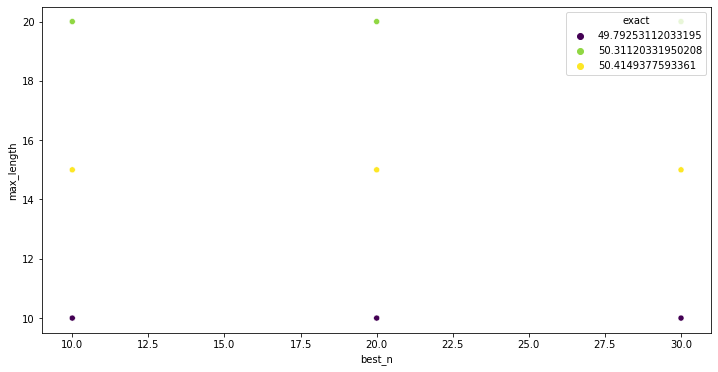

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12,6))
sns.scatterplot(x = 'best_n' , y = 'max_length' , data = df , hue = 'exact' , palette = 'viridis')

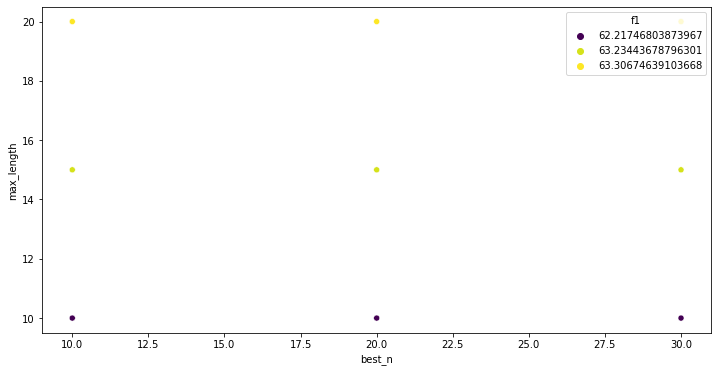

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12,6))
sns.scatterplot(x = 'best_n' , y = 'max_length' , data = df , hue = 'f1' , palette = 'viridis')

In [70]:
references[15]

{'answers': {'answer_start': [390], 'text': ['بایرن مونیخ']}, 'id': 1719487.0}

In [71]:
formatted_predictions[15]

{'id': 1719487.0,
 'no_answer_probability': 0.0,
 'prediction_text': ' بایرن مونیخ'}